In [ ]:
# Luka Lelovic
# CSI 4352
# Project

In [ ]:
# preprocessing code
import numpy as np
import glob
import random
import cv2
import os

def resize(image, mask, zoom_factor=1, size=(128, 128)):
  image = cv2.resize(image, size, fx=zoom_factor, fy=zoom_factor)
  mask = cv2.resize(mask, size, fx=zoom_factor, fy=zoom_factor)
  return image, mask

def flip(image, mask):
  if random.random() > 0.5:
    image = cv2.flip(image, 1)
    mask = cv2.flip(mask, 1)
  return image, mask

def rotate(image, mask):
  # apply rotation randomly (10% of time)
  if random.random() > 0.9:
    rotation_angle = random.uniform(-45, 45)  # degree range

    img_matrix = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), rotation_angle, 1)
    image = cv2.warpAffine(image, img_matrix, (image.shape[1], image.shape[0]))

    mask_matrix = cv2.getRotationMatrix2D((mask.shape[1] // 2, mask.shape[0] // 2), rotation_angle, 1)
    mask = cv2.warpAffine(mask, mask_matrix, (mask.shape[1], mask.shape[0]))
  return image, mask

def preprocess_data(path):
  image_path = os.path.join(path, 'images/*.jpg')
  mask_path = os.path.join(path, 'masks/*.png')
  print(image_path, mask_path)

  image_names = glob.glob(image_path)
  image_names.sort()

  mask_names = glob.glob(mask_path)
  mask_names.sort()

  images = []
  masks = []

  for i in range(len(image_names)):
    img = cv2.imread(image_names[i], 0)
    mask = cv2.imread(mask_names[i], 0)

    zoom_factor = 1

    # apply zoom randomly (10% of time)
    if random.random() > 0.9:
      zoom_factor = 1.5

    img, mask = resize(img, mask, zoom_factor=zoom_factor)
    img, mask = flip(img, mask)
    img, mask = rotate(img, mask)

    # binary mask color (0 or 255)
    mask = (mask >= 75).astype(np.uint8) * 255

    images.append(img)
    masks.append(mask)

  images = np.array(images)
  images = np.expand_dims(images, axis=3)

  masks = np.array(masks)
  masks = np.expand_dims(masks, axis=3)

  return images, masks

In [ ]:
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/drive')

# load images and masks
img_dataset = readImages('/drive/MyDrive/cracks-and-potholes-in-road/images/*.jpg')
mask_dataset = readImages('/drive/MyDrive/cracks-and-potholes-in-road/masks/*.png', True)

print("Image shape:", img_dataset.shape)
print("Mask shape:", mask_dataset.shape)
print("Image max:", np.max(img_dataset))
print("Mask labels:", np.unique(mask_dataset))

Mounted at /drive
Image shape: (2000, 128, 128, 1)
Mask shape: (2000, 128, 128, 1)
Image max: 255
Mask labels: [  0 255]


In [ ]:
img_dataset = img_dataset/255. # normalize
mask_dataset = mask_dataset/255. # rescale

X_train, X_test, y_train, y_test = train_test_split(img_dataset, mask_dataset, test_size = 0.20, random_state = 42)

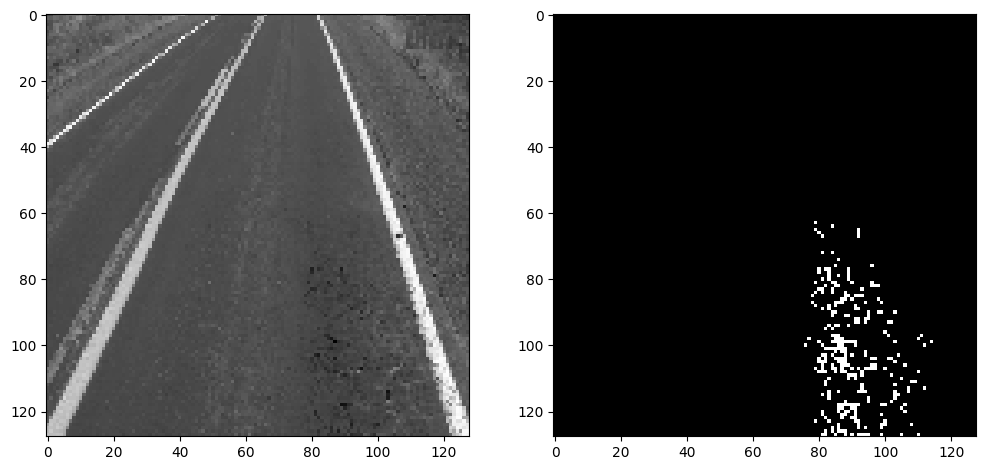

In [ ]:
import matplotlib.pyplot as plt
import random

# sanity check
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
# model code
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, MaxPool2D, Concatenate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2, 2))(x)
  p = Dropout(0.3)(p)

  return x, p

# Decoder block: skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = Dropout(0.3)(x)
  x = conv_block(x, num_filters)
  return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024) # Bottleneck

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  if n_classes == 1: # Binary
    activation = 'sigmoid'
  else:
    activation = 'softmax'

  outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
  print(activation)

  model = Model(inputs, outputs, name="U-Net")
  return model

def calcLoss(hist):
  # get model loss
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(epochs, acc, 'y', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusionMatrix(model, X_train, y_train):
  # Predictions
  y_train_pred = model.predict(X_train)

  # Threshold predictions to convert probabilities to binary values
  y_train_pred_binary = np.round(y_train_pred)

  # Compute confusion matrix
  conf_matrix_train = confusion_matrix(y_train.flatten(), y_train_pred_binary.flatten())

  # Convert confusion matrix to percentages
  conf_matrix_train_percentage = conf_matrix_train / conf_matrix_train.sum() * 100

  # Compute precision and recall for training set
  precision_train = conf_matrix_train[1, 1] / (conf_matrix_train[1, 1] + conf_matrix_train[0, 1])
  recall_train = conf_matrix_train[1, 1] / (conf_matrix_train[1, 1] + conf_matrix_train[1, 0])
  balanced_accuracy_train = 0.5 * (recall_train + precision_train)

  print('Precision (Training Set):', precision_train)
  print('Recall (Training Set):', recall_train)
  print('Balanced Accuracy (Training Set):', balanced_accuracy_train)

  # Plot confusion matrix for training set
  plt.figure(figsize=(6, 6))
  disp_train = ConfusionMatrixDisplay(conf_matrix_train_percentage, display_labels=[0, 1])
  disp_train.plot(cmap='viridis', values_format='.2f', ax=plt.gca(), colorbar=False)
  plt.title('Confusion Matrix - Training Set')

  # Display balanced accuracy rate in a box on the graph
  plt.figtext(0.5, 0.01, f'Balanced Accuracy (Training Set): {balanced_accuracy_train:.4f}',
                wrap=True, horizontalalignment='center', fontsize=10)

  plt.show()

In [ ]:
# train the model
from tensorflow.keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
import numpy as np
import random
import os

model_path = "./pothole_segmentation_model.h5"

if os.path.exists(model_path):
  # load the existing model from the .h5 file
  model = load_model(model_path)
else:
  IMG_HEIGHT = img_dataset.shape[1]
  IMG_WIDTH  = img_dataset.shape[2]
  IMG_CHANNELS = img_dataset.shape[3]

  input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

  model = build_unet(input_shape=input_shape, n_classes=1)

  model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

  # get model parameters
  print(model.summary())

  NUM_EPOCHS = 64
  BATCH_SIZE = 32
  STEPS_PER_EPOCH = 32

  # train the model
  hist = model.fit(X_train, y_train, batch_size=BATCH_SIZE, verbose=1, epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=(X_test, y_test), shuffle=False)

  # save the model
  model.save('pothole_segmentation_model.h5')

  calcLoss(hist)

  confusionMatrix(model, X_train, X_test, y_train, y_test)

# IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('True Mask')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predicted Mask')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
!pip install python-dotenv

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tensorflow.keras.models import load_model
import requests
import numpy as np
import io
import cv2
import os

load_dotenv()

choice1 = input('Are you uploading a street view image? (y/n) ')
img_name = ''
image = None

if choice1 == 'y':
  img_name = input('Path to image: ')

  image = cv2.imread(img_name)

  if image is None:
    print('Image not found:', img_name)
else:
  confirm = 'n'
  address = ''

  while confirm == 'n':
    street = input('Enter the street address: ')
    city_state = input('Enter the city, state: ')

    address = street + ', ' + city_state
    confirm = input('Is this correct? (y/n) ', address)

  # load api key from env file
  api_key = os.getenv('API_KEY')

  # street view parameters
  size = '400x400'  # image size
  fov = '90'        # field of view (zoom level)
  heading = '0'     # camera heading (0 is north)
  pitch = '0'       # camera pitch (0 is horizontal)

  print('Getting street view data at '+address+'')

  # construct the Street View image URL
  url = f'https://maps.googleapis.com/maps/api/streetview?location={address}&size={size}&fov={fov}&heading={heading}&pitch={pitch}&key={api_key}'

  # send a GET request to the API
  response = requests.get(url)
  print('Response:', response.status_code)

  # open the image using Pillow
  image = Image.open(io.BytesIO(response.content))

  # display the image using matplotlib
  plt.imshow(image)
  plt.axis('off')  # turn off axis labels
  plt.show()

  save = input('Save image? (y/n) ')
  if (save == 'y'):
    img_name = input('Image name: ')
    print('Saving image...')

    img_name = './'+img_name+'.jpg'

    # save the image to a file
    with open(img_name, 'wb') as f:
      f.write(response.content)
    response.close()

    print('Saved!')
    save = ''

  image = cv2.imread(img_name)

image = cv2.resize(image, (128, 128))

# perform preprocessing on image
grayscale_img = cv2.imread(img_name, 0)
grayscale_img = cv2.resize(grayscale_img, (128, 128))
grayscale_img = grayscale_img / 255.

model = load_model('pothole_segmentation_model.h5')

test_img = np.expand_dims(grayscale_img, 0)
prediction = (model.predict(test_img)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(image, cmap='gray')
plt.subplot(232)
plt.title('Predicted Mask')
plt.imshow(prediction, cmap='gray')

plt.show()